# Gym Trading With Ibovespa Market

## Load libs

In [1]:
# rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C, DQN, PPO

# gym stuff
import gym_trading_env
import gymnasium as gym
from gym_trading_env.renderer import Renderer
from gym_trading_env.downloader import download

# processing stuff
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime

# yahoo finance
import yfinance as yf

## Load Data

In [36]:
ticker = "PETR4.SA"

data = yf.download(ticker, start="2000-01-01", end="2024-01-01", )
data.to_csv(f"./data/{ticker.lower()}.csv")

stock = yf.Ticker(ticker)

intraday_data = stock.history(period="1y", interval="1h")
intraday_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-06-19 10:00:00-03:00,29.629999,29.799999,29.549999,29.740000,0,0.0,0.0
2023-06-19 11:00:00-03:00,29.740000,30.350000,29.730000,30.250000,8071900,0.0,0.0
2023-06-19 12:00:00-03:00,30.250000,30.280001,30.080000,30.200001,3781000,0.0,0.0
2023-06-19 13:00:00-03:00,30.200001,30.370001,30.180000,30.330000,3369100,0.0,0.0
2023-06-19 14:00:00-03:00,30.320000,30.410000,30.129999,30.270000,4901800,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-18 12:00:00-03:00,35.490002,35.730000,35.450001,35.570000,3448100,0.0,0.0
2024-06-18 13:00:00-03:00,35.570000,35.680000,35.520000,35.680000,2370100,0.0,0.0
2024-06-18 14:00:00-03:00,35.669998,35.860001,35.639999,35.810001,4517100,0.0,0.0


In [2]:
data = pd.read_csv("./data/petr4.sa.csv")
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data.drop(columns=["Adj Close"], inplace=True)
data.rename(columns={"Close": "close", "Open": "open", "High": "high", "Low": "low", "Volume": "volume"}, inplace=True)
data

,open,high,low,close,volume
Date,,,,,
2000-01-03,5.875000,5.875000,5.875000,5.875000,35389440000
2000-01-04,5.550000,5.550000,5.550000,5.550000,28861440000
2000-01-05,5.494000,5.494000,5.494000,5.494000,43033600000
2000-01-06,5.475000,5.475000,5.475000,5.475000,34055680000
2000-01-07,5.500000,5.500000,5.500000,5.500000,20912640000
...,...,...,...,...,...
2023-12-21,36.669998,36.680000,36.070000,36.389999,30511900
2023-12-22,36.500000,36.799999,36.369999,36.740002,31234700
2023-12-26,36.860001,37.369999,36.830002,37.330002,23466800


In [3]:
renderer = Renderer(render_logs_dir="render_logs")
renderer.run()

 * Serving Flask app 'gym_trading_env.renderer'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [25/Jun/2024 14:37:39] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Jun/2024 14:37:44] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [25/Jun/2024 14:37:44] "GET /update_data/trading-v0_2024-06-18_17-58-52.pkl HTTP/1.1" 200 -
127.0.0.1 - - [25/Jun/2024 14:37:44] "GET /metrics HTTP/1.1" 200 -
[2024-06-25 14:38:41,832] ERROR in app: Exception on /update_data/trading-v0_2024-06-18_17-54-52.pkl [GET]
Traceback (most recent call last):
  File "c:\Users\mpps\anaconda3\envs\gymenv\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mpps\anaconda3\envs\gymenv\Lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\mpps\anaconda3\envs\gymenv\Lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv 

In [4]:
env = gym.make(
    "TradingEnv",
    name="trading-v0",
    df = data.iloc[:,:],
    positions = [-1, 0, 1],
    trading_fees = 0.01/100,
    borrow_interest_rate = 0.0003/100,
    windows=5
)

Market Return : 577.09%   |   Portfolio Return : -96.79%   |   


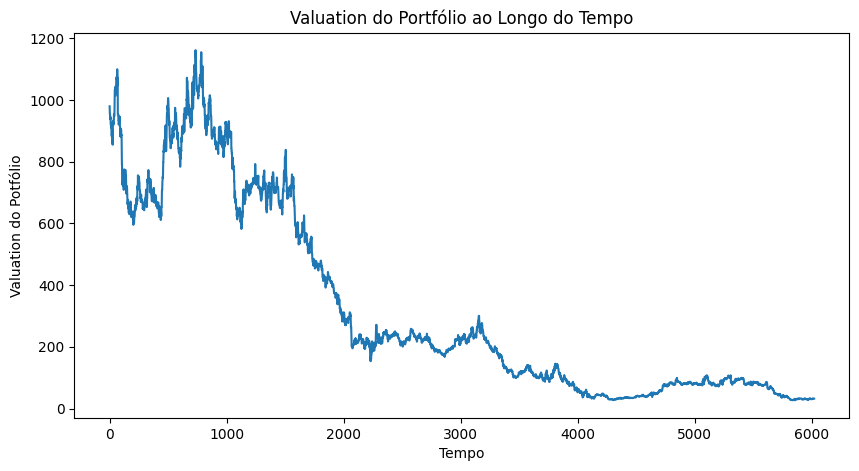

In [9]:
done, truncated = False, False
observation, info = env.reset()

portfolio_values = []
while not done and not truncated:
    action = env.action_space.sample()
    observation, reward, done, truncated, info = env.step(action)
    portfolio_values.append(info['portfolio_valuation'])
    
    if done or truncated:
        break
        
## data visualization
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values)
plt.title('Valuation do Portfólio ao Longo do Tempo')
plt.xlabel('Tempo')
plt.ylabel('Valuation do Potfólio')
plt.show()

env.env.unwrapped.save_for_render(dir = "render_logs")

In [10]:
# import gym
import gym_trading_env

import numpy as np
import pandas as pd

# Dados fictícios de dois ativos
data = {
    'Asset1': np.random.randn(100).cumsum() + 100,
    'Asset2': np.random.randn(100).cumsum() + 200,
}
df = pd.DataFrame(data)
print(df.head())

# Definindo o ambiente para múltiplos ativos
class MultiStockTradingEnv(gym.Env):
    def __init__(self, df, window_size):
        super(MultiStockTradingEnv, self).__init__()

        self.df = df
        self.window_size = window_size

        # Define a ação e o espaço de observação
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(df.shape[1],), dtype=np.float32)
        self.observation_space = gym.spaces.Box(
            low=-np.inf, high=np.inf, shape=(window_size, df.shape[1]), dtype=np.float32
        )
        self._reset()

    def _reset(self):
        self.current_step = self.window_size
        self.done = False
        self.current_state = self.df.iloc[:self.window_size].values
        return self.current_state

    def _step(self, action):
        if self.done:
            return self.current_state, 0, self.done, {}

        reward = 0  # Defina sua função de recompensa

        self.current_step += 1
        if self.current_step >= len(self.df):
            self.done = True
        else:
            self.current_state = self.df.iloc[self.current_step-self.window_size:self.current_step].values

        return self.current_state, reward, self.done, {}

    def reset(self):
        return self._reset()

    def step(self, action):
        return self._step(action)

    def render(self, mode='human', close=False):
        pass

# Parâmetros do ambiente
window_size = 10
env = MultiStockTradingEnv(df, window_size)

# Exemplo de uso do ambiente
state = env.reset()
for _ in range(100):
    action = env.action_space.sample()  # Ação aleatória
    state, reward, done, info = env.step(action)
    print(state, done)
    if done:
        break

       Asset1      Asset2
0  100.311071  200.956494
1  100.084406  200.790383
2   99.867290  201.737191
3   99.406961  202.875289
4   98.003912  203.067550
[[100.08440626 200.79038283]
 [ 99.8672896  201.73719087]
 [ 99.40696078 202.87528906]
 [ 98.00391209 203.06755035]
 [ 97.87060185 204.53296274]
 [ 96.66945797 204.41193275]
 [ 97.17908969 204.05098896]
 [ 96.56259156 204.67644544]
 [ 97.33813997 205.05342077]
 [ 99.34124602 204.93954971]] False
[[ 99.8672896  201.73719087]
 [ 99.40696078 202.87528906]
 [ 98.00391209 203.06755035]
 [ 97.87060185 204.53296274]
 [ 96.66945797 204.41193275]
 [ 97.17908969 204.05098896]
 [ 96.56259156 204.67644544]
 [ 97.33813997 205.05342077]
 [ 99.34124602 204.93954971]
 [ 99.53660699 204.35033834]] False
[[ 99.40696078 202.87528906]
 [ 98.00391209 203.06755035]
 [ 97.87060185 204.53296274]
 [ 96.66945797 204.41193275]
 [ 97.17908969 204.05098896]
 [ 96.56259156 204.67644544]
 [ 97.33813997 205.05342077]
 [ 99.34124602 204.93954971]
 [ 99.53660699 204

In [1]:
import yfinance as yf
import investpy as inv

br_stocks = inv.stocks.get_stocks('brazil')
br_stocks.to_csv('./data/br_stocks.csv')
br_stocks

,country,name,full_name,isin,currency,symbol
0,brazil,ABC BRASIL PN,Banco ABC Brasil SA,BRABCBACNPR4,BRL,ABCB4
1,brazil,BRASILAGRO ON,BrasilAgro - Co ON NM,BRAGROACNOR7,BRL,AGRO3
2,brazil,RUMO ON NM,RUMO Logistica Operadora Multimodal SA,BRRAILACNOR9,BRL,RAIL3
3,brazil,ALPARGATAS ON,Alpargatas SA,BRALPAACNOR0,BRL,ALPA3
4,brazil,ALPARGATAS PN,Alpargatas SA,BRALPAACNPR7,BRL,ALPA4
...,...,...,...,...,...,...
744,brazil,Integral Brei Reit,Fdo Inv Imob Fof Integral Brei Reit,BRIBFFCTF007,BRL,IBFF11
745,brazil,Vbi Cri,Fi Imobiliario Vbi Cri,BRCVBICTF001,BRL,CVBI11
746,brazil,Hedge Realty,Hedge Realty Devl Fdo Inv Imob Etf,BRHRDFCTF000,BRL,HRDF11
747,brazil,Rb Cap,Rb Cap Desenvolvimento Res Iii Fii,BRRSPDCTF006,BRL,RSPD11


In [2]:
wallet = []

for stock in br_stocks['symbol']:
    if len(stock) <= 5:
        wallet.append(stock + ".SA")

print(wallet)


['ABCB4.SA', 'AGRO3.SA', 'RAIL3.SA', 'ALPA3.SA', 'ALPA4.SA', 'ALSO3.SA', 'AMAR3.SA', 'ABEV3.SA', 'ADHM3.SA', 'ARZZ3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBRK3.SA', 'BEEF3.SA', 'BPHA3.SA', 'BPAN4.SA', 'BRAP3.SA', 'BRAP4.SA', 'BRFS3.SA', 'APER3.SA', 'BRKM3.SA', 'BRKM5.SA', 'BRML3.SA', 'BRPR3.SA', 'BRSR6.SA', 'OIBR3.SA', 'OIBR4.SA', 'BTOW3.SA', 'B3SA3.SA', 'CAMB4.SA', 'CARD3.SA', 'CCPR3.SA', 'CCRO3.SA', 'CEDO4.SA', 'CEED3.SA', 'CESP6.SA', 'CGAS5.SA', 'CGRA4.SA', 'CIEL3.SA', 'CMIG3.SA', 'CMIG4.SA', 'COCE5.SA', 'CPFE3.SA', 'CPLE3.SA', 'CPLE6.SA', 'CRDE3.SA', 'CSAN3.SA', 'CSMG3.SA', 'CSNA3.SA', 'LIQO3.SA', 'CTNM4.SA', 'CYRE3.SA', 'DASA3.SA', 'DIRR3.SA', 'DTEX3.SA', 'ECOR3.SA', 'EEEL3.SA', 'ELEK4.SA', 'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'ENGI4.SA', 'EQTL3.SA', 'YDUQ3.SA', 'ETER3.SA', 'EUCA4.SA', 'EVEN3.SA', 'EZTC3.SA', 'FESA4.SA', 'FHER3.SA', 'TASA4.SA', 'FLRY3.SA', 'FRIO3.SA', 'TIET3.SA', 'TIET4.SA', 'GFSA3.SA', 'GGBR3.SA', 'GGBR4.SA', 'GOAU3.SA', 'GOAU4.SA', 'GOLL4.SA', 'GR

In [4]:
stock_data = yf.download(wallet, start="2000-01-01", end="2021-01-01", group_by="ticker")
stock_data.to_csv("./data/br_stocks_data.csv")
stock_data

Failed to get ticker 'TIET2.SA' reason: unsupported pickle protocol: 5
[                       1%%                      ]  2 of 389 completed

[                       1%%                      ]  4 of 389 completedFailed to get ticker 'TIET3.SA' reason: unsupported pickle protocol: 5
Failed to get ticker 'LAME3.SA' reason: unsupported pickle protocol: 5
[*                      2%%                      ]  7 of 389 completedFailed to get ticker 'BIDI3.SA' reason: unsupported pickle protocol: 5
[*                      2%%                      ]  8 of 389 completedFailed to get ticker 'SMLS3.SA' reason: unsupported pickle protocol: 5
[*                      3%%                      ]  10 of 389 completedailed to get ticker 'DMMO3.SA' reason: unsupported pickle protocol: 5
[**                     4%%                      ]  16 of 389 completedFailed to get ticker 'BIDI4.SA' reason: unsupported pickle protocol: 5
[***                    6%%                      ]  24 of 389 completedFailed to get ticker 'MEND5.SA' reason: unsupported pickle protocol: 5
[***                    6%%                      ]  25 of 389 completedFailed to 

Empty DataFrame
Columns: [(ARZZ3.SA, Open), (ARZZ3.SA, High), (ARZZ3.SA, Low), (ARZZ3.SA, Close), (ARZZ3.SA, Adj Close), (ARZZ3.SA, Volume), (TIET2.SA, Open), (TIET2.SA, High), (TIET2.SA, Low), (TIET2.SA, Close), (TIET2.SA, Adj Close), (TIET2.SA, Volume), (CTKA4.SA, Open), (CTKA4.SA, High), (CTKA4.SA, Low), (CTKA4.SA, Close), (CTKA4.SA, Adj Close), (CTKA4.SA, Volume), (FESA4.SA, Open), (FESA4.SA, High), (FESA4.SA, Low), (FESA4.SA, Close), (FESA4.SA, Adj Close), (FESA4.SA, Volume), (CRPG6.SA, Open), (CRPG6.SA, High), (CRPG6.SA, Low), (CRPG6.SA, Close), (CRPG6.SA, Adj Close), (CRPG6.SA, Volume), (TIET3.SA, Open), (TIET3.SA, High), (TIET3.SA, Low), (TIET3.SA, Close), (TIET3.SA, Adj Close), (TIET3.SA, Volume), (LAME3.SA, Open), (LAME3.SA, High), (LAME3.SA, Low), (LAME3.SA, Close), (LAME3.SA, Adj Close), (LAME3.SA, Volume), (SLCE3.SA, Open), (SLCE3.SA, High), (SLCE3.SA, Low), (SLCE3.SA, Close), (SLCE3.SA, Adj Close), (SLCE3.SA, Volume), (BIDI3.SA, Open), (BIDI3.SA, High), (BIDI3.SA, Low), (BIDI3.SA, Close), (BIDI3.SA, Adj Close), (BIDI3.SA, Volume), (SMLS3.SA, Open), (SMLS3.SA, High), (SMLS3.SA, Low), (SMLS3.SA, Close), (SMLS3.SA, Adj Close), (SMLS3.SA, Volume), (TRPL3.SA, Open), (TRPL3.SA, High), (TRPL3.SA, Low), (TRPL3.SA, Close), (TRPL3.SA, Adj Close), (TRPL3.SA, Volume), (DMMO3.SA, Open), (DMMO3.SA, High), (DMMO3.SA, Low), (DMMO3.SA, Close), (DMMO3.SA, Adj Close), (DMMO3.SA, Volume), (CGAS5.SA, Open), (CGAS5.SA, High), (CGAS5.SA, Low), (CGAS5.SA, Close), (CGAS5.SA, Adj Close), (CGAS5.SA, Volume), (CSRN3.SA, Open), (CSRN3.SA, High), (CSRN3.SA, Low), (CSRN3.SA, Close), (CSRN3.SA, Adj Close), (CSRN3.SA, Volume), (BPHA3.SA, Open), (BPHA3.SA, High), (BPHA3.SA, Low), (BPHA3.SA, Close), (BPHA3.SA, Adj Close), (BPHA3.SA, Volume), (MGEL4.SA, Open), (MGEL4.SA, High), (MGEL4.SA, Low), (MGEL4.SA, Close), (MGEL4.SA, Adj Close), (MGEL4.SA, Volume), (CCRO3.SA, Open), (CCRO3.SA, High), (CCRO3.SA, Low), (CCRO3.SA, Close), ...]
Index: []

[0 rows x 2334 columns]

In [1]:
import yfinance as yf

dow_jones = yf.download("^DJI", start="2000-01-01", end="2024-01-01")


/Users/paulaperazzo/Documents/pibic/index-tracking/gym-trading-bovespa/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[*********************100%%**********************]  1 of 1 completed


In [44]:
dji = pd.read_csv("./data/dow_jones_index.csv")
dji_close = dji[["Ticker", "Adj Close"]]
dji_close.to_csv("./data/dow_jones_index_close.csv")
dji_close

,Ticker,Adj Close
0,2000-01-03,11357.509766
1,2000-01-04,10997.929688
2,2000-01-05,11122.650391
3,2000-01-06,11253.259766
4,2000-01-07,11522.559570
...,...,...
6032,2023-12-22,37385.968750
6033,2023-12-26,37545.328125
6034,2023-12-27,37656.519531
6035,2023-12-28,37710.101562


In [3]:
dow_jones.to_csv("./data/dow_jones_index.csv")

In [8]:
import investpy as inv

# Get the list of companies in the Dow Jones index
dow_jones_stocks = inv.stocks.get_stocks(country="united states")

# Print the list of companies in the Dow Jones index
dow_jones_stocks


,country,name,full_name,isin,currency,symbol
0,united states,Boeing,Boeing Co,US0970231058,USD,BA
1,united states,General Motors,General Motors Company,US37045V1008,USD,GM
2,united states,Chevron,Chevron Corp,US1667641005,USD,CVX
3,united states,Citigroup,Citigroup Inc,US1729674242,USD,C
4,united states,Bank of America,Bank of America Corp,US0605051046,USD,BAC
...,...,...,...,...,...,...
4577,united states,JBG SMITH Properties,JBG SMITH Properties,US46590V1008,USD,JBGS
4578,united states,Delphi Tech,Delphi Technologies PLC,JE00BD85SC56,USD,DLPH
4579,united states,nVent Electric,nVent Electric PLC,IE00BDVJJQ56,USD,NVT
4580,united states,Resideo Tech,Resideo Technologies Inc,US76118Y1047,USD,REZI


In [9]:
wallet = []

for stock in dow_jones_stocks['symbol']:
    if len(stock) <= 5:
        wallet.append(stock + ".SA")

print(wallet)

['BA.SA', 'GM.SA', 'CVX.SA', 'C.SA', 'BAC.SA', 'T.SA', 'CAT.SA', 'INTC.SA', 'MSFT.SA', 'AA.SA', 'F.SA', 'EBAY.SA', 'DELL.SA', 'DIS.SA', 'DOW.SA', 'CSCO.SA', 'DE.SA', 'FDX.SA', 'GIS.SA', 'GLW.SA', 'GT.SA', 'GS.SA', 'JPM.SA', 'KMB.SA', 'KHC.SA', 'KO.SA', 'MCD.SA', 'LLY.SA', 'ORCL.SA', 'MRK.SA', 'MSI.SA', 'MMM.SA', 'ODP.SA', 'CAKFF.SA', 'PMMAF.SA', 'VRTX.SA', 'MNST.SA', 'TEVA.SA', 'FITB.SA', 'SHLDQ.SA', 'CTAS.SA', 'ADSK.SA', 'DISH.SA', 'GILD.SA', 'LIFE.SA', 'GOOGL.SA', 'FISV.SA', 'LBTYA.SA', 'PDLI.SA', 'ADBE.SA', 'BB.SA', 'QCOM.SA', 'SINA.SA', 'BIDU.SA', 'SOHU.SA', 'DISCA.SA', 'RBBN.SA', 'AMAT.SA', 'STLD.SA', 'CDNS.SA', 'BBBY.SA', 'MCHP.SA', 'WYNN.SA', 'ISRG.SA', 'NDAQ.SA', 'RYAAY.SA', 'APLO.SA', 'INFY.SA', 'JBLU.SA', 'SPAR.SA', 'HSIC.SA', 'PAYX.SA', 'VRSN.SA', 'AAPL.SA', 'FAST.SA', 'XRAY.SA', 'CROX.SA', 'ZION.SA', 'NTRS.SA', 'CTXS.SA', 'LAMR.SA', 'PTEN.SA', 'ATLC.SA', 'CHRW.SA', 'SIRI.SA', 'ALPN.SA', 'PCAR.SA', 'PAAS.SA', 'AMZN.SA', 'ROST.SA', 'VIAV.SA', 'NTES.SA', 'NTAP.SA', 'ETFC.SA', 

In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL for the Wikipedia page that lists Dow Jones companies
url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'

# Send a GET request to fetch the page content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Locate the table containing the Dow Jones components
table = soup.find('table', {'class': 'wikitable'})

# Parse the table into a pandas DataFrame
df = pd.read_html(str(table))[0]

# Print the DataFrame
print(df[['Company', 'Symbol']])


               Company Symbol
0                   3M    MMM
1     American Express    AXP
2                Amgen   AMGN
3               Amazon   AMZN
4                Apple   AAPL
5               Boeing     BA
6          Caterpillar    CAT
7              Chevron    CVX
8                Cisco   CSCO
9            Coca-Cola     KO
10              Disney    DIS
11                 Dow    DOW
12       Goldman Sachs     GS
13          Home Depot     HD
14           Honeywell    HON
15                 IBM    IBM
16               Intel   INTC
17   Johnson & Johnson    JNJ
18      JPMorgan Chase    JPM
19          McDonald's    MCD
20               Merck    MRK
21           Microsoft   MSFT
22                Nike    NKE
23    Procter & Gamble     PG
24          Salesforce    CRM
25           Travelers    TRV
26  UnitedHealth Group    UNH
27             Verizon     VZ
28                Visa      V
29             Walmart    WMT


/var/folders/xh/n_j2f34x3gbbkjmhhfy63yc00000gn/T/ipykernel_6586/1262685162.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]


In [22]:
dji_symbols = df['Symbol'].tolist()
dji_symbols

['MMM',
 'AXP',
 'AMGN',
 'AMZN',
 'AAPL',
 'BA',
 'CAT',
 'CVX',
 'CSCO',
 'KO',
 'DIS',
 'DOW',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'JPM',
 'MCD',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'CRM',
 'TRV',
 'UNH',
 'VZ',
 'V',
 'WMT']

In [27]:
stock_data = yf.download(dji_symbols, start="2000-01-01", end="2024-01-01", group_by="ticker")
stock_data.to_csv("./data/dji_stocks_data.csv")
stock_data

[*********************100%%**********************]  30 of 30 completed


Ticker            WMT                                                        \
Price            Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2000-01-03  22.791668  23.000000  21.833332  22.270832  14.419454  25109700   
2000-01-04  21.833332  21.937500  21.395832  21.437500  13.879897  20235300   
2000-01-05  21.291668  21.458332  20.729168  21.000000  13.596639  21056100   
2000-01-06  21.000000  21.520832  20.895832  21.229168  13.745020  19633500   
2000-01-07  21.500000  22.979168  21.500000  22.833332  14.783654  23930700   
...               ...        ...        ...        ...        ...       ...   
2023-12-22  51.816666  52.383331  51.720001  52.216667  51.859924  19405500   
2023-12-26  52.216667  52.330002  52.036667  52.136665  51.780468  11679900   
2023-12-27  52.103333  52.650002  52.053333  52.626667  52.267120  19896000   
2023-12-28  52.590000  52.776669  52.500000  52.523335  52.164497  16776000   
2023-12-29  52.509998  52.693333  52.386665  52.549999  52.190979  21948300   

Ticker              BA                                      ...         HON  \
Price             Open        High         Low       Close  ...         Low   
Date                                                        ...               
2000-01-03   41.437500   41.687500   39.812500   40.187500  ...   53.865379   
2000-01-04   40.187500   41.125000   39.750000   40.125000  ...   51.541538   
2000-01-05   41.375000   43.312500   41.375000   42.625000  ...   52.137398   
2000-01-06   42.625000   43.437500   41.125000   43.062500  ...   51.958637   
2000-01-07   43.687500   44.875000   43.687500   44.312500  ...   53.805794   
...                ...         ...         ...         ...  ...         ...   
2023-12-22  261.829987  262.839996  259.200012  260.440002  ...  204.960007   
2023-12-26  259.799988  263.760010  259.540009  262.790009  ...  205.789993   
2023-12-27  262.630005  264.660004  260.899994  262.100006  ...  207.160004   
2023-12-28  261.529999  262.100006  257.679993  260.350006  ...  208.830002   
2023-12-29  260.670013  262.220001  259.559998  260.660004  ...  208.910004   

Ticker                                              CRM              \
Price            Close   Adj Close   Volume        Open        High   
Date                                                                  
2000-01-03   54.044136   31.130274  2203553         NaN         NaN   
2000-01-04   53.090767   30.581108  2800908         NaN         NaN   
2000-01-05   52.375736   30.169262  3121245         NaN         NaN   
2000-01-06   53.388695   30.752735  2504800         NaN         NaN   
2000-01-07   56.248802   32.400200  4136277         NaN         NaN   
...                ...         ...      ...         ...         ...   
2023-12-22  205.639999  203.438751  1889700  267.260010  268.149994   
2023-12-26  208.039993  205.813065  1860200  265.529999  266.529999   
2023-12-27  209.020004  206.782593  2340100  265.940002  267.010010   
2023-12-28  209.169998  206.930969  1647700  266.500000  266.920013   
2023-12-29  209.710007  207.465195  2256400  265.010010  265.649994   

Ticker                                                     
Price              Low       Close   Adj Close     Volume  
Date                                                       
2000-01-03         NaN         NaN         NaN        NaN  
2000-01-04         NaN         NaN         NaN        NaN  
2000-01-05         NaN         NaN         NaN        NaN  
2000-01-06         NaN         NaN         NaN        NaN  
2000-01-07         NaN         NaN         NaN        NaN  
...                ...         ...         ...        ...  
2023-12-22  265.299988  266.339996  265.579132  3109900.0  
2023-12-26  264.619995  266.220001  265.459503  3218800.0  
2023-12-27  265.399994  266.720001  265.958038  3387000.0  
2023-12-28  265.299988  265.579987  264.821289  2958700.0  
2023-12-29 

In [31]:
### get only the adj close prices
adj_close_values = []

for stock in dji_symbols:
    adj_close_values.append(stock_data[stock]['Adj Close'])

adj_close_values = pd.DataFrame(adj_close_values).T
adj_close_values.columns = dji_symbols
adj_close_values

,MMM,AXP,AMGN,AMZN,AAPL,BA,CAT,CVX,CSCO,KO,...,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,19.920656,32.757160,44.925068,4.468750,0.844004,25.940283,12.809783,16.968464,36.330013,14.219770,...,26.545698,36.000633,4.620289,27.901293,NaN,17.822495,5.377778,16.908840,NaN,14.419454
2000-01-04,19.129103,31.520309,41.489883,4.096875,0.772846,25.899939,12.645140,16.968464,34.291840,14.235540,...,25.613403,34.784527,4.368272,27.364412,NaN,17.586214,5.308995,16.362265,NaN,13.879897
2000-01-05,19.683189,30.719723,42.917496,3.487500,0.784155,27.513636,12.941504,17.272831,34.186779,14.361647,...,26.619299,35.151295,4.620289,26.843786,NaN,17.451189,5.296487,16.908840,NaN,13.596639
2000-01-06,21.266285,31.345583,43.631283,3.278125,0.716296,27.796036,13.600109,18.008394,33.619446,14.377416,...,26.840097,33.973785,4.596287,28.080248,NaN,17.788740,5.490337,16.822952,NaN,13.745020
2000-01-07,21.688435,31.801964,48.538696,3.478125,0.750226,28.602888,14.044657,18.325439,35.594585,15.323297,...,29.416161,34.417751,4.596287,30.325357,NaN,18.497580,6.134420,16.698732,NaN,14.783654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,86.848930,183.853470,279.967377,153.419998,192.868134,260.440002,286.803223,147.925827,48.881687,57.411739,...,106.384697,373.215393,107.236305,142.584457,265.579132,184.045853,516.077576,35.696575,256.957214,51.859924
2023-12-26,88.302818,184.239868,279.711182,153.410004,192.320221,262.790009,292.008667,149.257706,49.067101,57.648003,...,106.315559,373.295135,107.216446,143.232224,265.459503,185.323669,515.799866,35.687054,257.683075,51.780468
2023-12-27,88.817398,185.329681,282.302399,153.339996,192.419830,262.100006,294.468170,148.768051,49.223240,57.795666,...,106.661285,372.707275,106.333069,143.350006,265.958038,186.839218,518.537415,35.525188,257.454376,52.267120


In [35]:
print(adj_close_values.columns)
print(len(adj_close_values.columns))

Index(['MMM', 'AXP', 'AMGN', 'AMZN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
       'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD',
       'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WMT'],
      dtype='object')
30


In [39]:
# sample with mean value for missing values
adj_close_values = adj_close_values.fillna(adj_close_values.mean())
adj_close_values.rename(columns={"Date": "Ticker"}, inplace=True)
adj_close_values.to_csv("./data/dji_stocks_adj_close.csv")
adj_close_values

,MMM,AXP,AMGN,AMZN,AAPL,BA,CAT,CVX,CSCO,KO,...,MRK,MSFT,NKE,PG,CRM,TRV,UNH,VZ,V,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,19.920656,32.757160,44.925068,4.468750,0.844004,25.940283,12.809783,16.968464,36.330013,14.219770,...,26.545698,36.000633,4.620289,27.901293,81.670256,17.822495,5.377778,16.908840,97.918845,14.419454
2000-01-04,19.129103,31.520309,41.489883,4.096875,0.772846,25.899939,12.645140,16.968464,34.291840,14.235540,...,25.613403,34.784527,4.368272,27.364412,81.670256,17.586214,5.308995,16.362265,97.918845,13.879897
2000-01-05,19.683189,30.719723,42.917496,3.487500,0.784155,27.513636,12.941504,17.272831,34.186779,14.361647,...,26.619299,35.151295,4.620289,26.843786,81.670256,17.451189,5.296487,16.908840,97.918845,13.596639
2000-01-06,21.266285,31.345583,43.631283,3.278125,0.716296,27.796036,13.600109,18.008394,33.619446,14.377416,...,26.840097,33.973785,4.596287,28.080248,81.670256,17.788740,5.490337,16.822952,97.918845,13.745020
2000-01-07,21.688435,31.801964,48.538696,3.478125,0.750226,28.602888,14.044657,18.325439,35.594585,15.323297,...,29.416161,34.417751,4.596287,30.325357,81.670256,18.497580,6.134420,16.698732,97.918845,14.783654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,86.848930,183.853470,279.967377,153.419998,192.868134,260.440002,286.803223,147.925827,48.881687,57.411739,...,106.384697,373.215393,107.236305,142.584457,265.579132,184.045853,516.077576,35.696575,256.957214,51.859924
2023-12-26,88.302818,184.239868,279.711182,153.410004,192.320221,262.790009,292.008667,149.257706,49.067101,57.648003,...,106.315559,373.295135,107.216446,143.232224,265.459503,185.323669,515.799866,35.687054,257.683075,51.780468
2023-12-27,88.817398,185.329681,282.302399,153.339996,192.419830,262.100006,294.468170,148.768051,49.223240,57.795666,...,106.661285,372.707275,106.333069,143.350006,265.958038,186.839218,518.537415,35.525188,257.454376,52.267120
